In [14]:
import pandas as pd
from scipy.stats import zscore
from haversine import haversine
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
import numpy as np
import matplotlib.pyplot as plt

In [15]:
data = pd.read_excel('data/newph.xlsx')

In [16]:
data.columns

Index(['price', 'lnprice', 'pricemeter', 'lnpricemeter', 'district', 'DZ',
       'IN', 'MO', 'SV', 'OR', 'KI', 'LE', 'rooms', 'housefloor', 'firstfloor',
       'totalfloor', 'livesq', 'kitsq', 'totalsq', 'house_type', 'PG', 'HR',
       'BR', 'IP', 'SP', 'UP', 'LP', 'MG', 'MS', 'ST', 'brick', 'panel',
       'realtor', 'dist_super', 'dist_hyper', 'longitude', 'latitude', '500_m',
       '1000_m', '238_m'],
      dtype='object')

In [17]:
data.describe()

,price,lnprice,pricemeter,lnpricemeter,DZ,IN,MO,SV,OR,KI,...,brick,panel,realtor,dist_super,dist_hyper,longitude,latitude,500_m,1000_m,238_m
count,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,...,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000
mean,2965.014858,7.888035,56.722408,4.016386,0.164237,0.155683,0.159515,0.185520,0.122973,0.161568,...,0.522617,0.477383,0.875111,0.194911,6.623320,56.202230,58.015188,4.383015,12.675494,1.277630
std,1729.913123,0.434118,11.751800,0.212090,0.370503,0.362567,0.366169,0.388732,0.328417,0.368067,...,0.499505,0.499505,0.330604,0.145001,4.845025,0.130129,0.043282,3.619809,7.572576,1.647042
min,295.000000,5.686975,7.879433,2.064256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.001413,0.023542,55.827973,57.944565,0.000000,0.000000,0.000000
25%,2050.000000,7.625595,48.983051,3.891474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.105629,2.045820,56.152927,57.987595,2.000000,7.000000,0.000000
50%,2550.000000,7.843849,55.555556,4.017384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.166479,4.824859,56.225009,58.004865,4.000000,11.000000,1.000000
75%,3300.000000,8.101678,63.829787,4.156220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.250092,11.626932,56.290112,58.028654,5.000000,16.000000,2.000000
max,27800.000000,10.232791,112.121212,4.719581,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.599272,18.730365,56.612610,58.166159,28.000000,41.000000,21.000000


## Cleaning, remove outliers, add feature

In [18]:
def reject_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """Function removes outliers
    :param df: Original DataFrame
    :return: Updated DataFrame
    """
    for column in ['pricemeter', 'price', 'totalsq']:
        df = df[zscore(df[column].values) < 3]
    return df
    
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Function removes excess columns
    :param df: Original DataFrame
    :return: Updated DataFrame
    """
    excess_columns = ['pricemeter','district','DZ','IN', 'MO', 'SV', 'OR', 'KI', 'LE', 'lnprice', 'lnpricemeter','house_type', '500_m', '1000_m', '238_m', 'realtor', 'firstfloor']
    df.drop(excess_columns, inplace = True, axis = 1)
    df = df[df.livesq + df.kitsq < df.totalsq] # total square must be more than sum of livesq and kitsq
    return df 

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """Function adds feature
    :param df: Original DataFrame
    :return: Updated DataFrame
    """
    center_point = [58.011293, 56.237305] #central point
    df['distance from center'] = list(map(lambda point: haversine(center_point, point), df[['latitude', 'longitude']].values))
    df.drop(['latitude', 'longitude'], inplace = True, axis = 1)
    return df

In [19]:
data = add_features(clean_data(reject_outliers(data)))

In [28]:
data.head()

,price,rooms,housefloor,firstfloor,totalfloor,livesq,kitsq,totalsq,PG,HR,...,LP,MG,MS,ST,brick,panel,realtor,dist_super,dist_hyper,distance from center
0,1900.0,2,2.0,0,NaN,29.0,6.0,44.0,1,0,...,0,0,0,0,0,1,1,0.336884,4.105095,4.284032
1,1900.0,2,2.0,0,NaN,28.0,6.0,42.0,1,0,...,0,0,0,0,0,1,1,0.336884,4.105095,4.284032
3,2000.0,2,2.0,0,3.0,28.0,5.8,43.0,0,1,...,0,0,0,0,1,0,1,0.979376,2.282306,9.765179
5,2145.0,2,4.0,0,5.0,30.0,5.7,44.0,0,0,...,0,0,0,0,0,1,1,0.954352,2.155892,9.742223
6,2399.0,1,4.0,0,5.0,31.0,6.0,47.0,0,0,...,0,0,0,0,0,1,1,0.954352,2.155892,9.742223


In [20]:
data.describe()

,price,rooms,housefloor,firstfloor,totalfloor,livesq,kitsq,totalsq,PG,HR,...,LP,MG,MS,ST,brick,panel,realtor,dist_super,dist_hyper,distance from center
count,7997.000000,7997.000000,7997.000000,7997.000000,6621.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,...,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000
mean,2702.740939,1.971989,4.427785,0.188571,8.477571,30.169257,8.002385,49.717519,0.067275,0.204202,...,0.026010,0.001250,0.031012,0.007003,0.498687,0.501313,0.891334,0.193254,6.665955,7.819302
std,981.621859,0.871404,3.596409,0.391192,4.778349,11.855690,2.718464,16.871112,0.250514,0.403142,...,0.159174,0.035342,0.173360,0.083393,0.500030,0.500030,0.311239,0.137123,4.844037,5.556490
min,295.000000,1.000000,1.000000,0.000000,2.000000,6.000000,1.000000,12.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001413,0.023542,0.086957
25%,2050.000000,1.000000,2.000000,0.000000,5.000000,18.000000,6.000000,36.200000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.106038,2.064155,3.537007
50%,2490.000000,2.000000,4.000000,0.000000,9.000000,29.600000,7.500000,45.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.166724,4.970314,5.653342
75%,3100.000000,3.000000,5.000000,0.000000,10.000000,39.000000,9.000000,60.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.250209,11.629358,12.486039
max,7600.000000,9.000000,25.000000,1.000000,26.000000,80.800000,45.000000,107.500000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.303981,18.439625,24.172379


## Catboost model

In [34]:
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [22]:
X.shape, y.shape

((7997, 23), (7997,))

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [36]:
scores = []
for train_index, test_index in kf.split(X, y):

    x_train, x_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_cb = CatBoostRegressor(eval_metric='RMSE')
    model_cb.fit(x_train, y_train, eval_set=[(x_test, y_test)],
                 early_stopping_rounds=20, use_best_model=True,
                 verbose=0)

    scores.append(model_cb.best_score_['validation']['RMSE'])
    model_cb.save_model(f'models/catboost{len(scores)}.cbm')

print('Average RMSE:', np.mean(scores))
for i, score in enumerate(scores):
    print(f'Model {i+1} RMSE: {score}')

Average RMSE: 305.1498654444552
Model 1 RMSE: 333.3950190600694
Model 2 RMSE: 294.1995214255935
Model 3 RMSE: 314.03080007941315
Model 4 RMSE: 298.0445692743758
Model 5 RMSE: 286.07941738282403


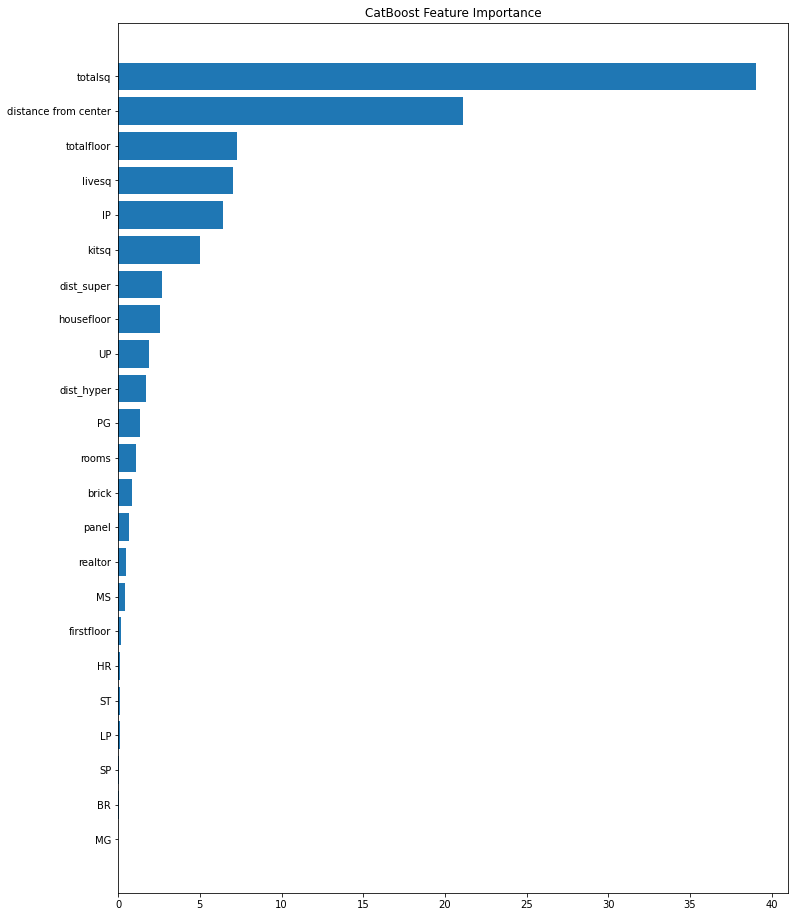

In [27]:
importance = pd.DataFrame({
    'features': X.columns,
    'importance': model_cb.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('CatBoost Feature Importance')
plt.show()